In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd

import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [2]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [3]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [4]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [5]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Load Models

In [18]:
checkpoint_path = "outdir_kc8/checkpoint_65000"
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])

<All keys matched successfully>

In [9]:
waveglow_path = '../models/waveglow_256channels_v4.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/home/jwyang/anaconda3/envs/mellotron/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Setup dataloaders

In [22]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'filelists/kss_audiopaths_text_sid_val_filelist.txt'
# audio_paths = 'filelists/test_filelist.txt'
# audio_paths = 'filelists/yuhuiyeol_audiopaths_text_sid_val_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

In [11]:
for i, a in enumerate(dataloader.audiopaths_and_text):
    print(i, a[1])

0 여러분 안녕하십니까 이월 십육일 일요일 엠비씨 뉴스입니다
1 코로나 일구로 멈춰섰던 스포츠도 차츰 돌아오고 있습니다
2 국내 코로나일구 확진 환자가 엿새만에 추가 확인 돼 모두 스물 아홉명으로 늘었습니다
3 오늘은 제가 녹음일을 하면서 맡는 아주 공통된 캐릭터들을 보여드릴게요
4 일자리를 구하려고 취업 박람회를 찾은겁니다
5 스물 아홉번째 추가 확진 환자는 최근 해외 여행을 간 적이 없는 여든 두살의 한국인 남성으로 확인됐습니다
6 근데 이 기술을 어떻게 익히셨을까 궁금했습니다
7 삼십퍼 센트 가량인 서른두개 노선의 운항을 재개한다고 공지했습니다
8 어깨는 꾸준히 단련 해야 하는 법
9 누군가 말했죠 전체는 부분의 합보다 더 큰 법이라고요
10 빼곡하게 줄이 늘어선 한 행사장 입니다 자세히 보면 머리가 희끗한 노인들이 보입니다


# Style Transfer (Rhythm and Pitch Contour)

In [23]:
file_idx = 2
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]
# print(dataloader[2])

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :].cuda()    
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

/home/jwyang/dataset/path_to_kss/4/4_2788.wav 저희는 아침 식사를 무료로 제공합니다.


In [24]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)

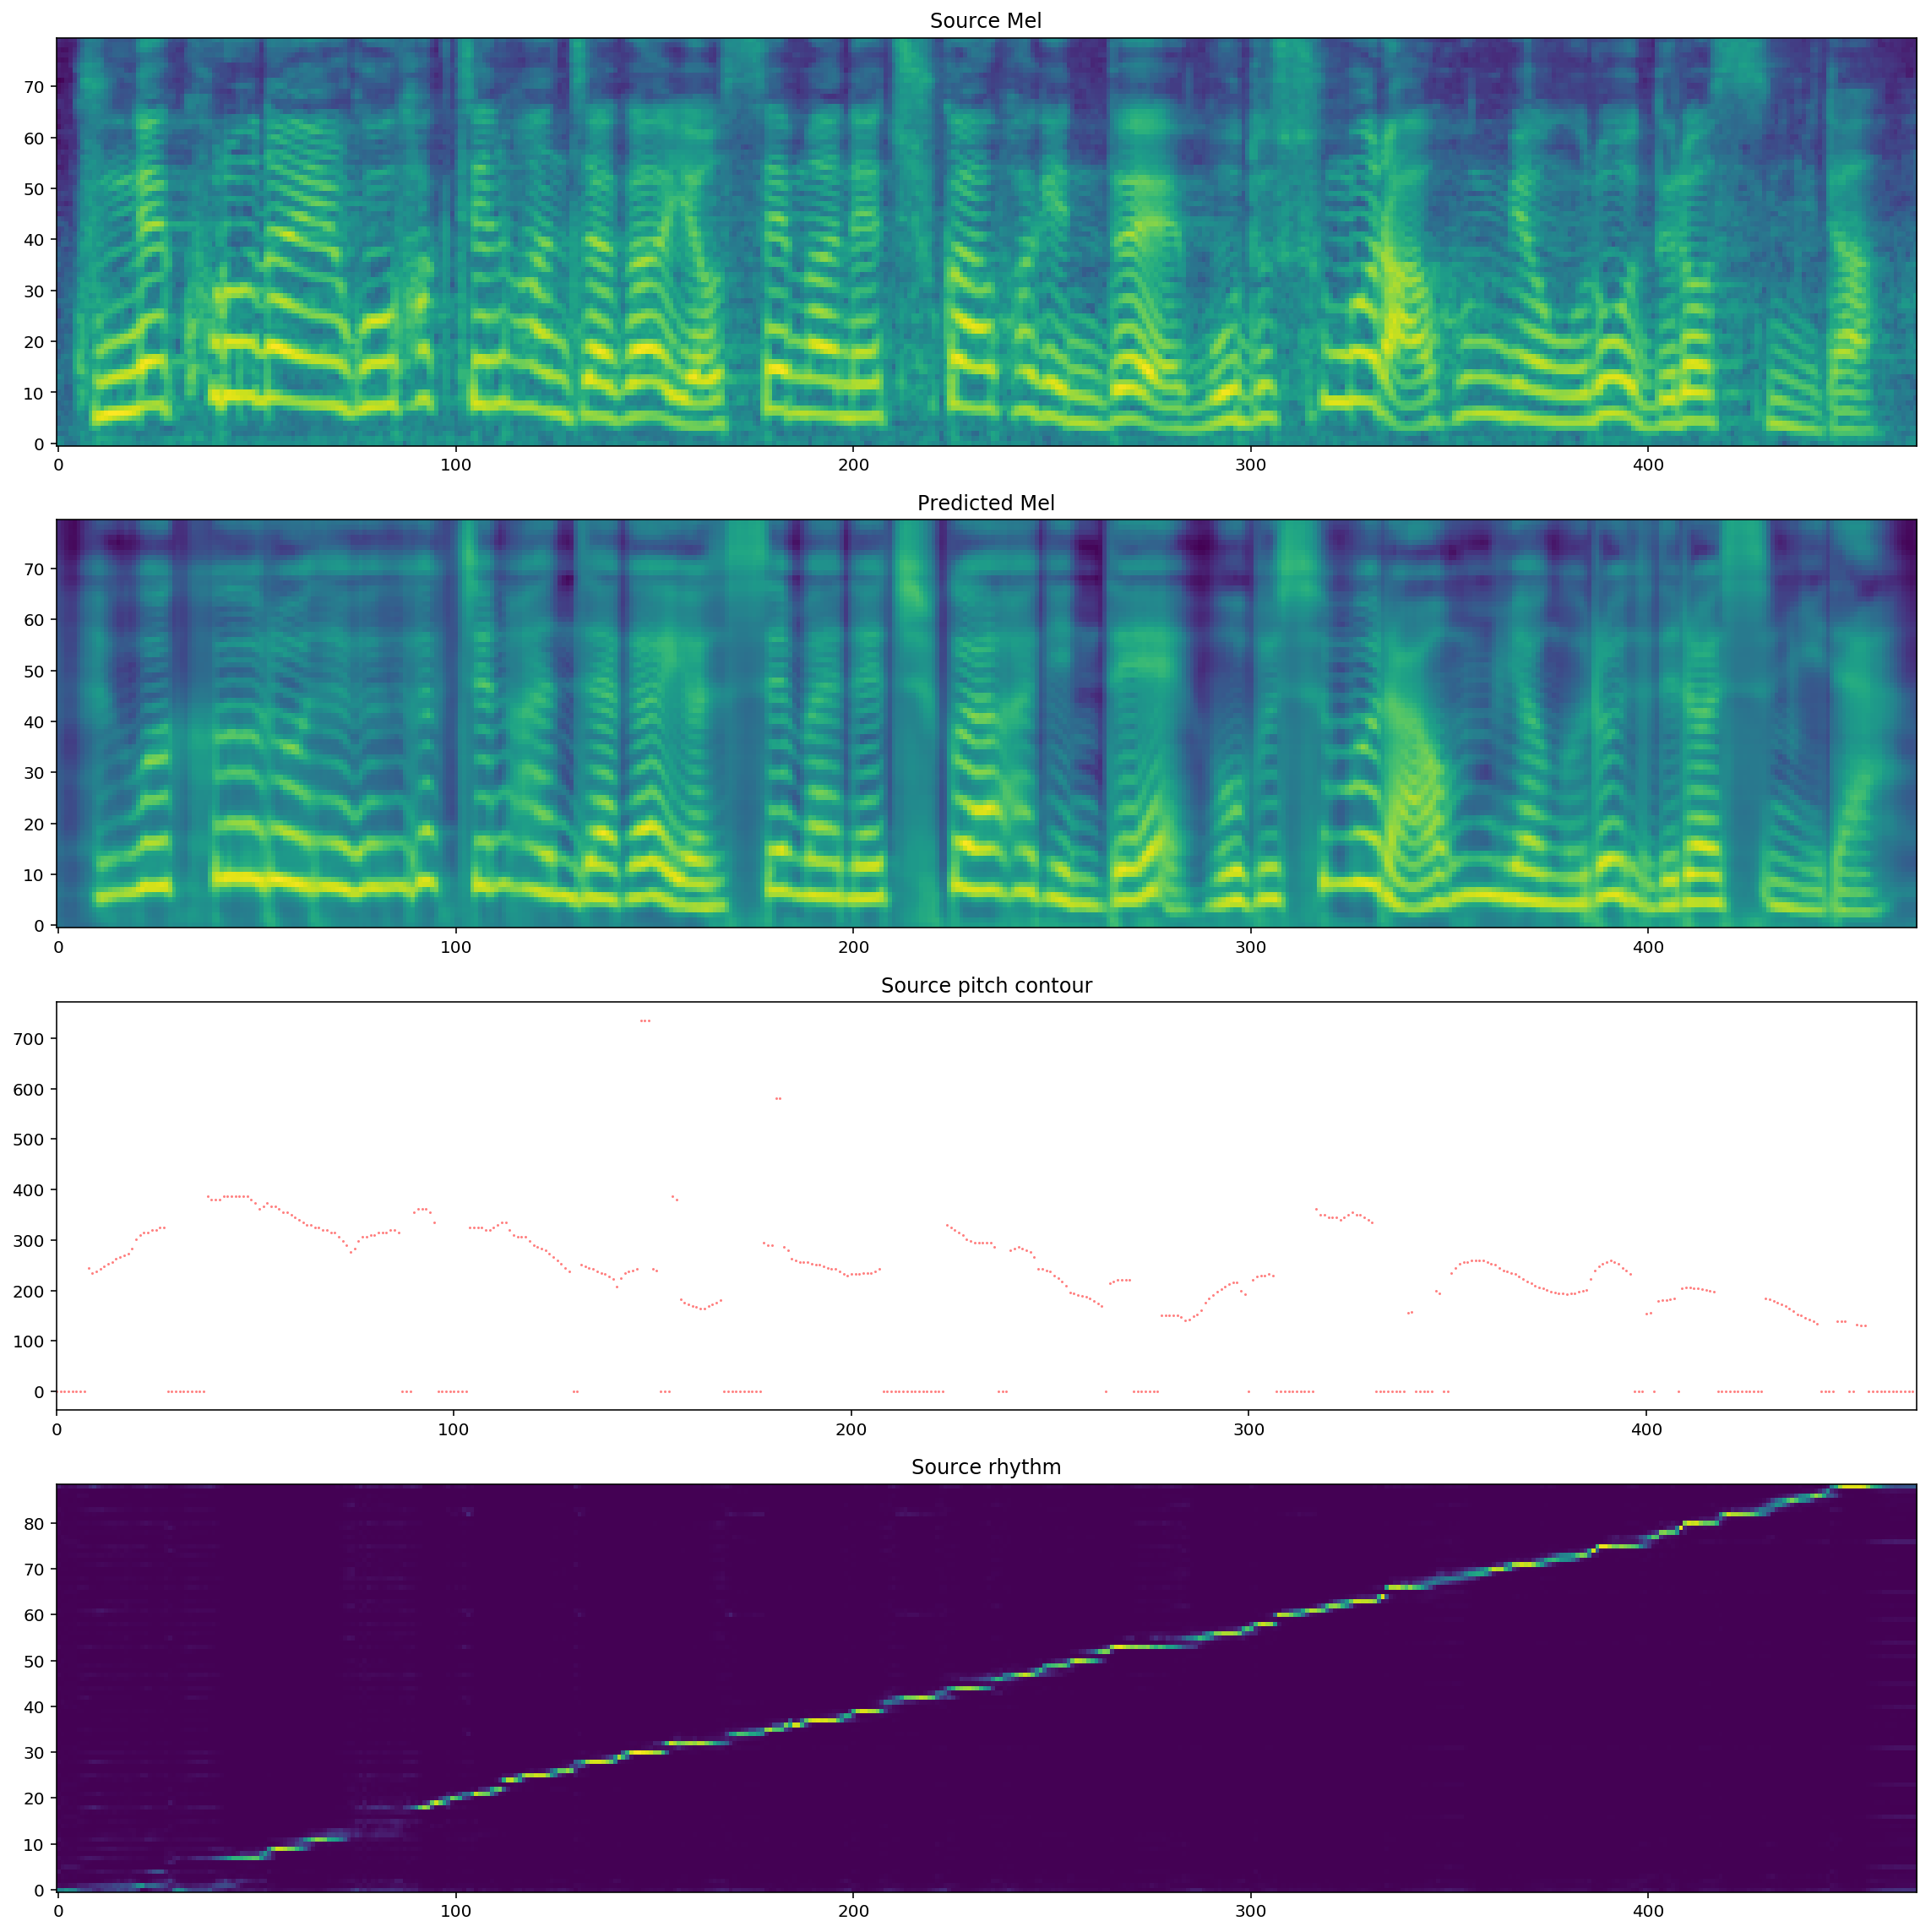

In [21]:
speaker_id = 0
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mellotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))
    
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.001)[:, 0]
    
plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)    

ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)